##Install Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install datasets
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.17.0
    Uninstalling peft-0.17.0:
      Successfully uninstalled p

In [ ]:
import os
import random
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)

import bitsandbytes as bnb

from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline,
    logging,
)

from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    PeftModel,
    PeftConfig,
)

from trl import SFTTrainer, setup_chat_format

import wandb
from google.colab import files
from google.colab import userdata


## Environment setup

In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

set_all_seeds(49)



In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


##Upload preprocessed datasets Make it compactable for analysis


In [ ]:
print("Please upload files for Aggression detection train data")
agg_train= files.upload()
agg_train= next(iter(agg_train))
agg_train=pd.read_csv(agg_train)

print("Please upload files for Aggression detection validation data")
agg_val= files.upload()
agg_val= next(iter(agg_val))
agg_val=pd.read_csv(agg_val)

print("Please upload files for d1")
d1_test= files.upload()
d1_test= next(iter(d1_test))
d1_test=pd.read_csv(d1_test)

print("Please upload files for d2 Agg test data")
d2_test= files.upload()
d2_test= next(iter(d2_test))
d2_test=pd.read_csv(d2_test)

print("Please upload files for d3 Agg test data")
d3_test= files.upload()
d3_test= next(iter(d3_test))
d3_test=pd.read_csv(d3_test)

print("Please upload files for d4 Agg test data")
d4_test= files.upload()
d4_test= next(iter(d4_test))
d4_test=pd.read_csv(d4_test)

print("Please upload files for d5 Agg test data")
d5_test= files.upload()
d5_test= next(iter(d5_test))
d5_test=pd.read_csv(d5_test)

Please upload files for Aggression detection train data


Saving agg_train.csv to agg_train.csv
Please upload files for Aggression detection validation data


Saving agg_val.csv to agg_val.csv
Please upload files for d1


Saving d1_test_with_cyb.csv to d1_test_with_cyb.csv
Please upload files for d2 Agg test data


Saving d2_test_with_cyb.csv to d2_test_with_cyb.csv
Please upload files for d3 Agg test data


Saving d3_test_with_cyb.csv to d3_test_with_cyb.csv
Please upload files for d4 Agg test data


Saving d4_test_with_cyb.csv to d4_test_with_cyb.csv
Please upload files for d5 Agg test data


Saving d5_test_with_cyb.csv to d5_test_with_cyb.csv


In [ ]:
agg_train.head()

,text,label
0,"""Asked if these files of historic value were s...",not aggressive
1,I have to say this. Without a civilian governm...,not aggressive
2,Ladies and Gentlemen This man wants to get awa...,overtly aggressive
3,Just curious are the BJP leaders sitting on dh...,covertly aggressive
4,US President Barack Obama congratulates [USER]...,not aggressive


In [ ]:
from sklearn.utils import resample
# Get minimum class count
min_count = agg_train['label'].value_counts().min()

# Resample each class
balanced_train_dfs = [resample(agg_train[agg_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in agg_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution
print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
not aggressive         6516
covertly aggressive    6516
overtly aggressive     6516
Name: count, dtype: int64


In [ ]:
balanced_train_df = balanced_train_df.reset_index(drop=True)
agg_val = agg_val.reset_index(drop=True)


In [ ]:
class_weights=(1/balanced_train_df.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = balanced_train_df
dataset_val =agg_val

dataset = DatasetDict({
    'train': Dataset.from_pandas(dataset_train),  # Convert to Dataset
    'val': Dataset.from_pandas(dataset_val)     # Convert to Dataset
})

class weights:tensor([0.3333, 0.3333, 0.3333])


In [ ]:
balanced_train_df.head()

,text,label
0,[USER] [USER] Fully understand. That is why I ...,not aggressive
1,But hazzare ji what u did after that??? [HASHT...,covertly aggressive
2,"""Asked if these files of historic value were s...",not aggressive
3,If people dont support and think he is not a g...,covertly aggressive
4,Its fake. Indians nothing have to say except b...,overtly aggressive


##Prompt for training and testing

In [ ]:
def create_training_prompt(row):
    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: Not provided

CLASSIFICATION: {row['label']}""".strip()

In [ ]:
balanced_train_df['text'] = balanced_train_df.apply(create_training_prompt, axis=1)
agg_val['text'] = agg_val.apply(create_training_prompt, axis=1)

In [ ]:
def generate_test_prompt(row):
  return f"""You are a strict Aggression classifier.
  Analyze the text and classify it into exactly one category:

  The possible categories are:
  - not aggressive: neutral or non-hostile statements
  - covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks
  - overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

  TEXT: "{row['text']}"

  Auxiliary information: Not provided

  CLASSIFICATION: """.strip()

In [ ]:
from datasets import Dataset
train_data = Dataset.from_pandas(balanced_train_df[['text']])
eval_data = Dataset.from_pandas(agg_val[['text']])

In [ ]:
train_data['text'][3]

'You are a strict Aggression classifier.\nAnalyze the text and classify it into exactly one category:\n\nThe possible categories are:\n- not aggressive: neutral or non-hostile statements\n- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks\n- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility\n\nTEXT: "If people dont support and think he is not a good PM Then who do you want to be PM The chota bheem lover Rahul So that he can telecast chota bheem on DD Or Kejriwal to Blame Trump or Putin on India\'s failure"\n\nAuxiliary information: Not provided\n\nCLASSIFICATION: covertly aggressive'

## MODEL SETUP AND FINE-TUNING

In [ ]:
# ============================================================================
# MODEL SETUP AND FINE-TUNING
# ============================================================================

# Model and Tokenizer Setup
model_name = "google/gemma-2-2b-it"

print("Loading model and tokenizer...")

# Configure 4-bit quantization for memory efficiency
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation='eager',
    device_map="auto",
    torch_dtype="float16",
    quantization_config=quant_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

print("Model loaded successfully!")


Loading model and tokenizer...


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
modules = find_all_linear_names(model)
modules

['q_proj', 'v_proj', 'gate_proj', 'down_proj', 'o_proj', 'k_proj', 'up_proj']

In [ ]:
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers import EarlyStoppingCallback

output_dir = "gemma2_aggr-model"

# PEFT Configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

# Use SFTConfig with "text" field
training_arguments = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=4,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=False,
    bf16=True,
    max_grad_norm=0.1,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="wandb",
    eval_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=1,
    dataloader_num_workers=4,

    # SFT-specific parameters
    dataset_text_field="text",
    max_length=512,
    packing=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_drop_last=True,

    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3,early_stopping_threshold=0.002)]
)


Adding EOS to train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss
100,0.991300,0.985188
200,1.028300,0.966978
300,0.971600,0.955332
400,1.034900,0.947610
500,0.948700,0.944365
600,1.005400,0.938872
700,0.969800,0.935007
800,0.912200,0.933084
900,0.941400,0.929573
1000,0.963000,0.931058


TrainOutput(global_step=2700, training_loss=0.959299193488227, metrics={'train_runtime': 8073.0116, 'train_samples_per_second': 7.264, 'train_steps_per_second': 0.908, 'total_flos': 3.945245376649421e+16, 'train_loss': 0.959299193488227})

In [ ]:
wandb.finish()
# After training
model.config.use_cache = True
model.gradient_checkpointing_disable()  # Add this line


eval/loss,█▆▆▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▂▂
eval/mean_token_accuracy,▁▁▃▄▄▅▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇██████
eval/num_tokens,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
eval/runtime,▁▄▂▂▃▂▇▆▄▅▅▅█▇▇▇▆▆███▇▇▆▇▇█
eval/samples_per_second,█▅▇▇▆▇▂▃▅▄▄▄▁▂▂▂▃▃▁▁▁▂▂▂▂▂▁
eval/steps_per_second,█▅▇▇▆▇▃▃▅▄▄▄▁▂▂▂▃▃▁▂▂▂▂▃▂▂▂
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▁▇▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▃▂
train/learning_rate,▄▁▄▅▇███████████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅
train/loss,▂█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▂▁▁▁▂▂▁▂▂▁▂▁▂▁▁▁▁▁


In [ ]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1-fine-tuned_aggr-model/tokenizer_config.json',
 'llama-3.1-fine-tuned_aggr-model/special_tokens_map.json',
 'llama-3.1-fine-tuned_aggr-model/chat_template.jinja',
 'llama-3.1-fine-tuned_aggr-model/tokenizer.model',
 'llama-3.1-fine-tuned_aggr-model/added_tokens.json',
 'llama-3.1-fine-tuned_aggr-model/tokenizer.json')

In [ ]:
model.gradient_checkpointing_disable()  # Add this line

##testing with Auxillary information and without auxillary information

In [ ]:
def evaluate(y_true, y_pred):
    labels =['not aggressive','covertly aggressive','overtly aggressive']
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)
    # Then plot with string labels
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories =['not aggressive','covertly aggressive','overtly aggressive']
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=15,
                        temperature=0.1)

        result = pipe(prompt)
        answer = result[0]['generated_text'].split("CLASSIFICATION:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():

                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


d1_test aggression prediction  without cyber bullying
Accuracy: 0.710
Accuracy for label not aggressive: 0.828
Accuracy for label covertly aggressive: 0.538
Accuracy for label overtly aggressive: 0.653

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.82      0.83      0.82        99
covertly aggressive       0.54      0.54      0.54        52
 overtly aggressive       0.67      0.65      0.66        49

           accuracy                           0.71       200
          macro avg       0.68      0.67      0.67       200
       weighted avg       0.71      0.71      0.71       200


Confusion Matrix:
[[82 10  7]
 [15 28  9]
 [ 3 14 32]]


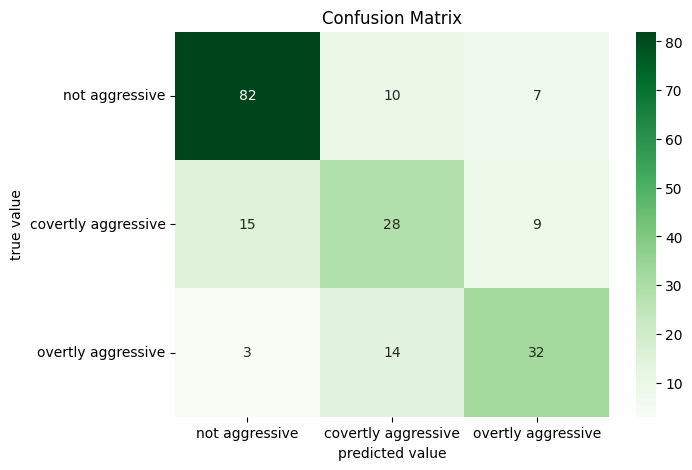

In [ ]:
# Generate test prompts and extract true labels
y_true = d1_test.loc[:, 'label']
X_test = pd.DataFrame(d1_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d1_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)

In [ ]:

def generate_test_prompt_cyb_detail_v1(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    # Only provide auxiliary info for high-confidence predictions
    if confidence >= 0.80:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

100%|██████████| 200/200 [01:33<00:00,  2.13it/s]

d1_test aggression prediction  with cyber bullying
Accuracy: 0.695
Accuracy for label not aggressive: 0.869
Accuracy for label covertly aggressive: 0.365
Accuracy for label overtly aggressive: 0.694

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.78      0.87      0.82        99
covertly aggressive       0.51      0.37      0.43        52
 overtly aggressive       0.64      0.69      0.67        49

           accuracy                           0.69       200
          macro avg       0.65      0.64      0.64       200
       weighted avg       0.68      0.69      0.68       200


Confusion Matrix:
[[86  7  6]
 [20 19 13]
 [ 4 11 34]]


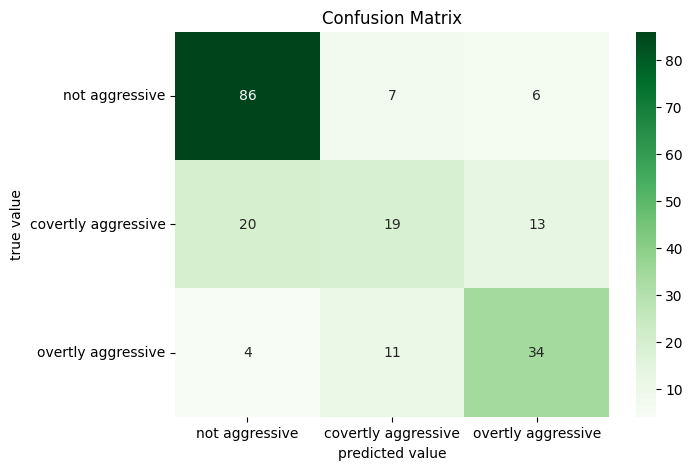

In [ ]:
# Generate test prompts and extract true labels
y_true = d1_test.loc[:, 'label']
X_test = pd.DataFrame(d1_test.apply(generate_test_prompt_cyb_detail_v1, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d1_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

100%|██████████| 777/777 [06:05<00:00,  2.13it/s]

d2_test aggression prediction  without cyber bullying
Accuracy: 0.606
Accuracy for label not aggressive: 0.850
Accuracy for label covertly aggressive: 0.311
Accuracy for label overtly aggressive: 0.509

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.70      0.85      0.77       367
covertly aggressive       0.48      0.31      0.38       251
 overtly aggressive       0.48      0.51      0.50       159

           accuracy                           0.61       777
          macro avg       0.55      0.56      0.55       777
       weighted avg       0.58      0.61      0.59       777


Confusion Matrix:
[[312  40  15]
 [101  78  72]
 [ 35  43  81]]


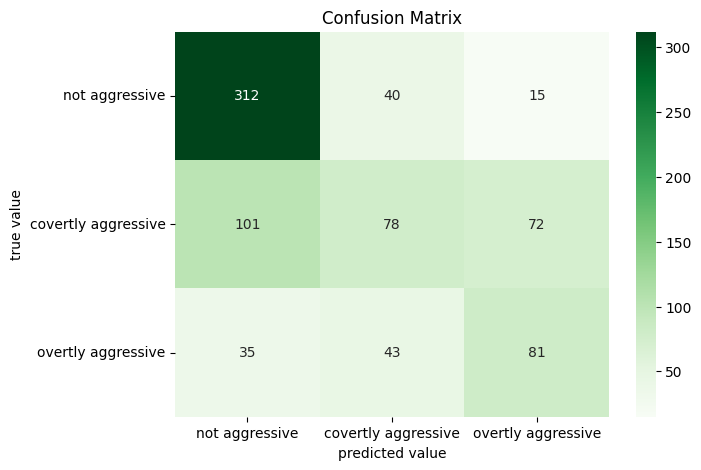

In [ ]:
# Generate test prompts and extract true labels
y_true = d2_test.loc[:, 'label']
X_test = pd.DataFrame(d2_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d2_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


100%|██████████| 777/777 [06:00<00:00,  2.15it/s]

d2_test aggression prediction  with cyber bullying
Accuracy: 0.606
Accuracy for label not aggressive: 0.850
Accuracy for label covertly aggressive: 0.247
Accuracy for label overtly aggressive: 0.610

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.70      0.85      0.77       367
covertly aggressive       0.50      0.25      0.33       251
 overtly aggressive       0.46      0.61      0.53       159

           accuracy                           0.61       777
          macro avg       0.56      0.57      0.54       777
       weighted avg       0.59      0.61      0.58       777


Confusion Matrix:
[[312  30  25]
 [101  62  88]
 [ 31  31  97]]


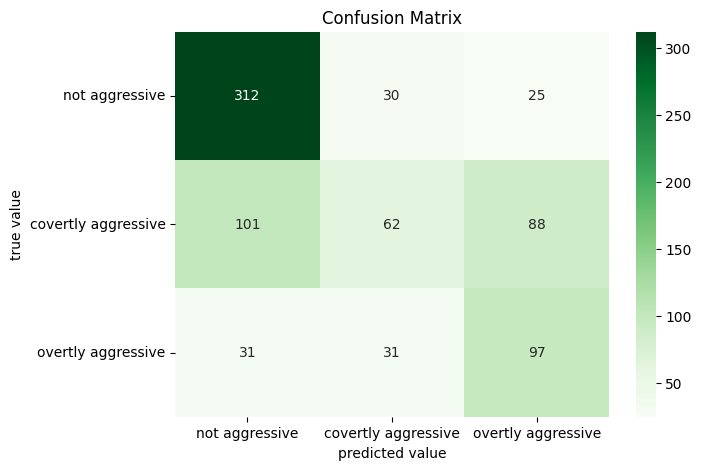

In [ ]:

# Generate test prompts and extract true labels
y_true = d2_test.loc[:, 'label']
X_test = pd.DataFrame(d2_test.apply(generate_test_prompt_cyb_detail_v1, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d2_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

100%|██████████| 1225/1225 [09:37<00:00,  2.12it/s]

d3_test aggression prediction  without cyber bullying
Accuracy: 0.682
Accuracy for label not aggressive: 0.864
Accuracy for label covertly aggressive: 0.422
Accuracy for label overtly aggressive: 0.708

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.73      0.86      0.79       544
covertly aggressive       0.68      0.42      0.52       410
 overtly aggressive       0.59      0.71      0.64       271

           accuracy                           0.68      1225
          macro avg       0.67      0.66      0.65      1225
       weighted avg       0.68      0.68      0.67      1225


Confusion Matrix:
[[470  32  42]
 [143 173  94]
 [ 29  50 192]]


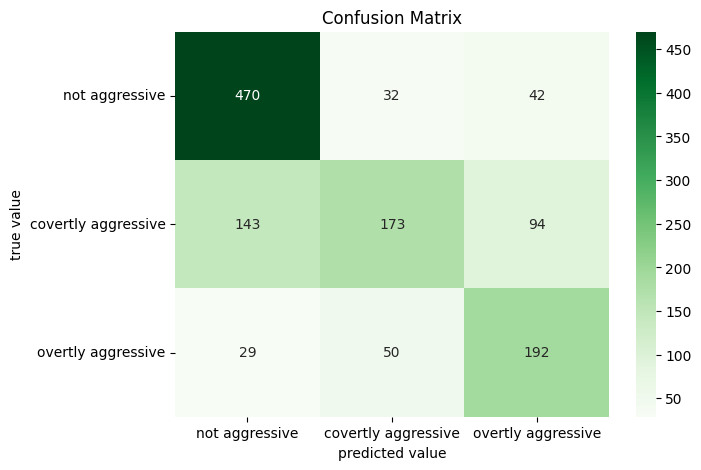

In [ ]:
# Generate test prompts and extract true labels
y_true = d3_test.loc[:, 'label']
X_test = pd.DataFrame(d3_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d3_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


100%|██████████| 533/533 [03:59<00:00,  2.22it/s]

d4_test aggression prediction  without cyber bullying
Accuracy: 0.762
Accuracy for label not aggressive: 0.854
Accuracy for label covertly aggressive: 0.121
Accuracy for label overtly aggressive: 0.737

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.89      0.85      0.87       418
covertly aggressive       0.29      0.12      0.17        58
 overtly aggressive       0.40      0.74      0.52        57

           accuracy                           0.76       533
          macro avg       0.52      0.57      0.52       533
       weighted avg       0.77      0.76      0.76       533


Confusion Matrix:
[[357  13  48]
 [ 35   7  16]
 [ 11   4  42]]


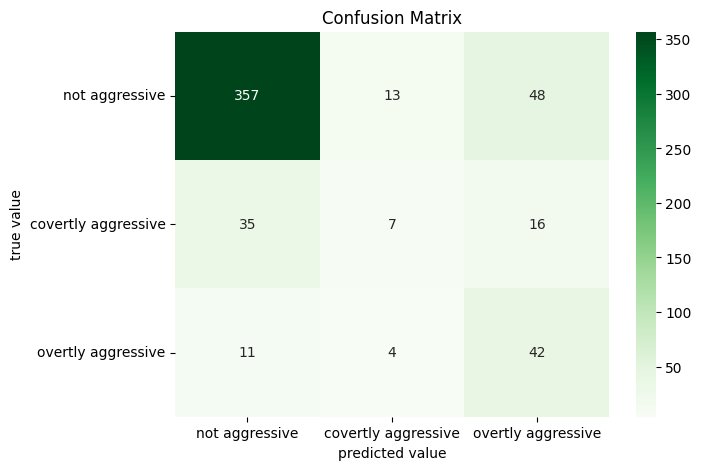

In [ ]:
# Generate test prompts and extract true labels
y_true = d4_test.loc[:, 'label']
X_test = pd.DataFrame(d4_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d4_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


100%|██████████| 1493/1493 [12:00<00:00,  2.07it/s]

d5_test aggression prediction  without cyber bullying
Accuracy: 0.594
Accuracy for label not aggressive: 0.716
Accuracy for label covertly aggressive: 0.418
Accuracy for label overtly aggressive: 0.642

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.68      0.72      0.70       616
covertly aggressive       0.51      0.42      0.46       522
 overtly aggressive       0.55      0.64      0.59       355

           accuracy                           0.59      1493
          macro avg       0.58      0.59      0.58      1493
       weighted avg       0.59      0.59      0.59      1493


Confusion Matrix:
[[441 119  56]
 [172 218 132]
 [ 39  88 228]]


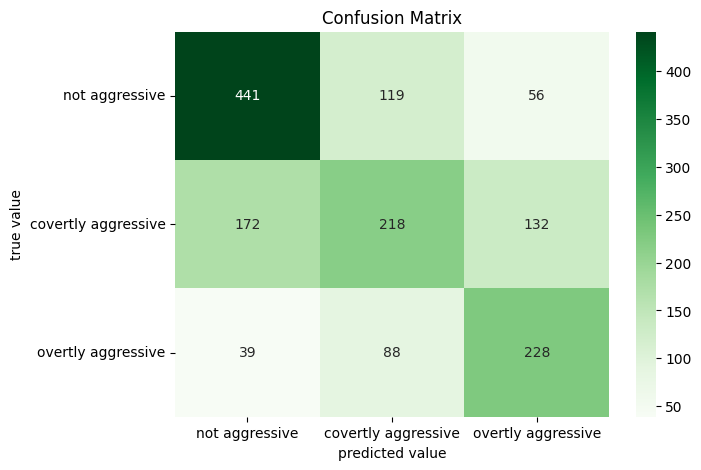

In [ ]:
# Generate test prompts and extract true labels
y_true = d5_test.loc[:, 'label']
X_test = pd.DataFrame(d5_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d5_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


In [ ]:
# Version 1: Confidence filtering + neutral language
def generate_test_prompt_cyb_detail_v2(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    # Only provide auxiliary info for high-confidence predictions
    if confidence >= 0.80:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs, indirect verbal attacks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

100%|██████████| 1225/1225 [09:28<00:00,  2.15it/s]

d3_test aggression prediction  with cyber bullying
Accuracy: 0.660
Accuracy for label not aggressive: 0.864
Accuracy for label covertly aggressive: 0.312
Accuracy for label overtly aggressive: 0.775

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.72      0.86      0.79       544
covertly aggressive       0.67      0.31      0.43       410
 overtly aggressive       0.55      0.77      0.64       271

           accuracy                           0.66      1225
          macro avg       0.65      0.65      0.62      1225
       weighted avg       0.67      0.66      0.63      1225


Confusion Matrix:
[[470  28  46]
 [157 128 125]
 [ 26  35 210]]


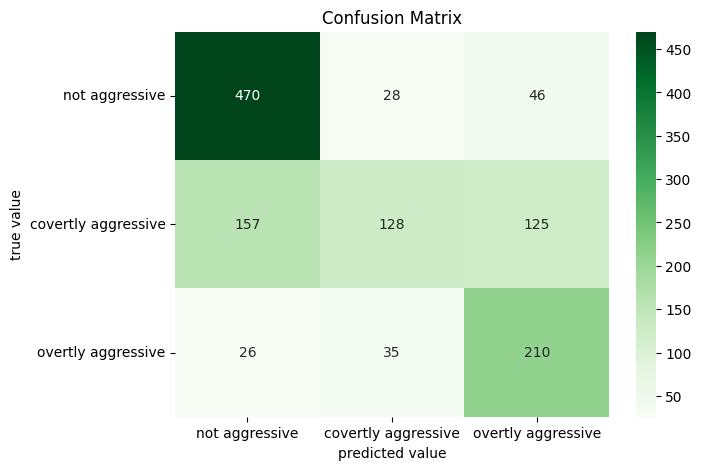

In [ ]:

# Generate test prompts and extract true labels
y_true = d3_test.loc[:, 'label']
X_test = pd.DataFrame(d3_test.apply(generate_test_prompt_cyb_detail_v2, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d3_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

100%|██████████| 533/533 [03:57<00:00,  2.24it/s]

d4_test aggression prediction  with cyber bullying
Accuracy: 0.760
Accuracy for label not aggressive: 0.842
Accuracy for label covertly aggressive: 0.103
Accuracy for label overtly aggressive: 0.825

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.88      0.84      0.86       418
covertly aggressive       0.40      0.10      0.16        58
 overtly aggressive       0.39      0.82      0.53        57

           accuracy                           0.76       533
          macro avg       0.56      0.59      0.52       533
       weighted avg       0.78      0.76      0.75       533


Confusion Matrix:
[[352   7  59]
 [ 38   6  14]
 [  8   2  47]]


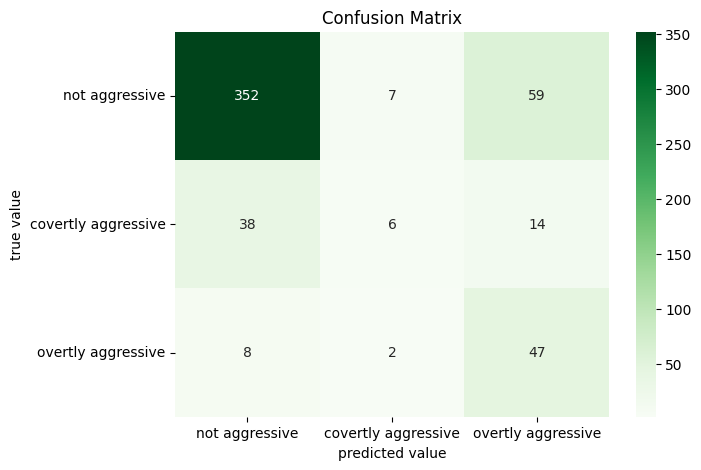

In [ ]:

# Generate test prompts and extract true labels
y_true = d4_test.loc[:, 'label']
X_test = pd.DataFrame(d4_test.apply(generate_test_prompt_cyb_detail_v2, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d4_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

In [ ]:
# Version 1: Confidence filtering + neutral language
def generate_test_prompt_cyb_detail_v3(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    # Only provide auxiliary info for high-confidence predictions
    if confidence >= 0.85:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs, indirect verbal attacks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

100%|██████████| 1493/1493 [11:49<00:00,  2.11it/s]

d5_test aggression prediction  with cyber bullying
Accuracy: 0.593
Accuracy for label not aggressive: 0.721
Accuracy for label covertly aggressive: 0.354
Accuracy for label overtly aggressive: 0.724

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.67      0.72      0.69       616
covertly aggressive       0.54      0.35      0.43       522
 overtly aggressive       0.53      0.72      0.61       355

           accuracy                           0.59      1493
          macro avg       0.58      0.60      0.58      1493
       weighted avg       0.59      0.59      0.58      1493


Confusion Matrix:
[[444 104  68]
 [178 185 159]
 [ 43  55 257]]


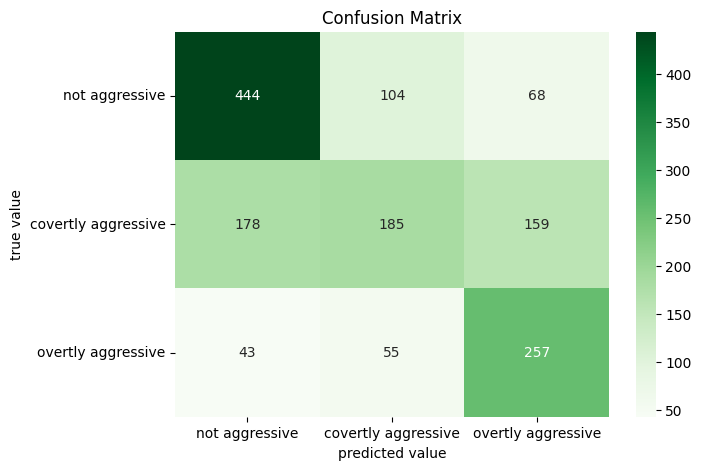

In [ ]:
y_true=d5_test.loc[:,'label']
X_test = pd.DataFrame(d5_test.apply(generate_test_prompt_cyb_detail_v3, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d5_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

100%|██████████| 1493/1493 [11:48<00:00,  2.11it/s]

d5_test aggression prediction  with cyber bullying
Accuracy: 0.594
Accuracy for label not aggressive: 0.726
Accuracy for label covertly aggressive: 0.354
Accuracy for label overtly aggressive: 0.718

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.67      0.73      0.70       616
covertly aggressive       0.53      0.35      0.43       522
 overtly aggressive       0.53      0.72      0.61       355

           accuracy                           0.59      1493
          macro avg       0.58      0.60      0.58      1493
       weighted avg       0.59      0.59      0.58      1493


Confusion Matrix:
[[447 100  69]
 [179 185 158]
 [ 39  61 255]]


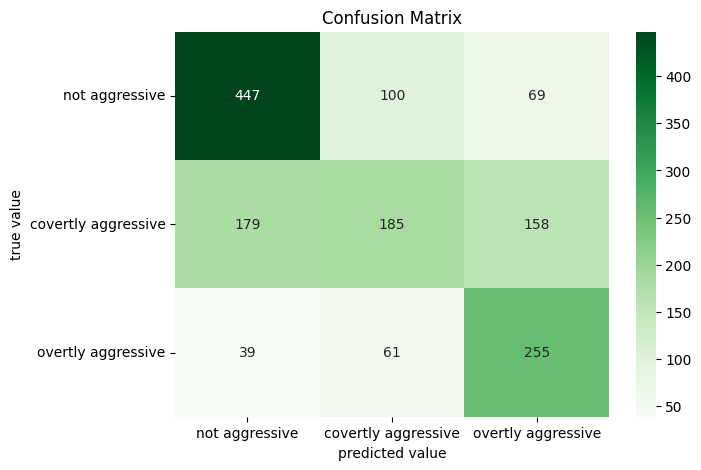

In [ ]:
y_true=d5_test.loc[:,'label']
X_test = pd.DataFrame(d5_test.apply(generate_test_prompt_cyb_detail_v3, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d5_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)